# Лабораторная работа: Рекомендательные системы

## Теоретическая часть

### 1. Суть задачи рекомендательных систем
Рекомендательные системы – это алгоритмы, которые анализируют поведение пользователей и предлагают персонализированные рекомендации товаров, фильмов, музыки и других объектов. Основная цель – предсказать предпочтения пользователей на основе имеющихся данных о взаимодействиях.


### 2. Метод коллаборативной фильтрации
Коллаборативная фильтрация (Collaborative Filtering, CF) – это метод рекомендаций, основанный на анализе поведения пользователей. Он работает на основе предположения, что пользователи с похожими предпочтениями в прошлом будут делать схожий выбор в будущем.

Существует два основных подхода:
1. **User-based CF** – рекомендации строятся на основе сходства пользователей.
2. **Item-based CF** – рекомендации строятся на основе сходства объектов.

### 3. Латентные факторные модели (Matrix Factorization)
Коллаборативная фильтрация может быть реализована через матричное разложение. Пусть у нас есть матрица взаимодействий пользователей и объектов R, где $( R_{u,i} )$ – оценка пользователя ( u ) для объекта ( i ). Тогда разложение можно представить в виде:
$$
R \approx U \cdot V^T
$$
где:
- ( U ) – матрица эмбеддингов пользователей,
- ( V ) – матрица эмбеддингов объектов.

Предсказание рейтинга рассчитывается как:
$$
\hat{R}_{u,i} = U_u \cdot V_i^T
$$

В данной лабораторной работе предполагается использование **нейросетевого метода**, который обучает эмбеддинги пользователей и объектов с помощью полносвязных слоев. Входные данные – индексы пользователей и объектов, которые преобразуются в векторные представления, а затем подаются на вход нейросети.


## Практическая часть
В данной работе вам предлагается реализовать рекомендательную систему на основе метода коллаборативной фильтрации, используя нейросетевую модель. Вы должны:
1. Подготовить данные: загрузить свой датасет (например, рейтинг фильмов, товаров, книг и т. д.).
2. Разбить данные на тренировочный и тестовый наборы.
3. Обучить модель, используя эмбеддинги пользователей и объектов.
4. Оценить качество модели на тестовом наборе.
5. Вывести список рекомендаций для выбранного пользователя.

In [99]:
# Импорты
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Определяем устройство (используем GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [100]:
# Определяем названия столбцов
columns = ['userID', 'songID', 'rating']
df = pd.read_csv('ratings.csv', names=columns, nrows=10000)
print(df.head())

   userID  songID  rating
0       0    7171       5
1       0    8637       4
2       0   21966       4
3       0   35821       5
4       0   82446       5


In [101]:
# Подготовка данных

# Преобразуем идентификаторы пользователей и фильмов (начинаем с 0 для удобства в PyTorch)
user_ids = df['userID'].unique()
user_mapping = {old_id: new_id for new_id, old_id in enumerate(user_ids)}
df['userID'] = df['userID'].map(user_mapping)

# Создаем маппинг для песен
item_ids = df['songID'].unique()
item_mapping = {old_id: new_id for new_id, old_id in enumerate(item_ids)}
df['songID'] = df['songID'].map(item_mapping)

# Приводим к целочисленному типу
df['userID'] = df['userID'].astype(int)
df['songID'] = df['songID'].astype(int)

print(f"ID перекодированы. Диапазон userID: 0-{df['userID'].max()}")
print(f"Диапазон songID: 0-{df['songID'].max()}")

ID перекодированы. Диапазон userID: 0-999
Диапазон songID: 0-7388


In [102]:
# Определяем датасет PyTorch
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['userID'].values, dtype=torch.long)
        self.items = torch.tensor(df['songID'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [103]:
# Определяем нейросетевую модель для коллаборативной фильтрации
class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(RecommenderNN, self).__init__()
        # Эмбеддинги пользователей и фильмов
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Полносвязные слои для предсказания рейтинга
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, item):
        # Получаем эмбеддинги пользователя и фильма
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        # Объединяем эмбеддинги
        x = torch.cat([user_emb, item_emb], dim=1)

        # Пропускаем через полносвязные слои
        return self.fc_layers(x).squeeze()

In [104]:
# Определяем количество пользователей и музыки
num_users = df['userID'].nunique()
num_items = df['songID'].nunique()


In [105]:
# Создаём датасеты и загрузчики данных
dataset = RatingsDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [106]:
# Инициализация модели
model = RecommenderNN(num_users, num_items).to(device)

# Определяем функцию потерь (MSE) и оптимизатор (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


Epoch 1/10 | Loss: 2.9526 | Train RMSE: 1.7183 | Train MAE: 1.4497
           | Test RMSE: 1.5337 | Test MAE: 1.3329
Epoch 2/10 | Loss: 1.9417 | Train RMSE: 1.3934 | Train MAE: 1.1792
           | Test RMSE: 1.4501 | Test MAE: 1.2251
Epoch 3/10 | Loss: 1.4841 | Train RMSE: 1.2183 | Train MAE: 0.9968
           | Test RMSE: 1.4225 | Test MAE: 1.1708
Epoch 4/10 | Loss: 1.1560 | Train RMSE: 1.0752 | Train MAE: 0.8605
           | Test RMSE: 1.4512 | Test MAE: 1.1906
Epoch 5/10 | Loss: 0.8612 | Train RMSE: 0.9280 | Train MAE: 0.7232
           | Test RMSE: 1.4565 | Test MAE: 1.1980
Epoch 6/10 | Loss: 0.5845 | Train RMSE: 0.7645 | Train MAE: 0.5860
           | Test RMSE: 1.5261 | Test MAE: 1.2576
Epoch 7/10 | Loss: 0.3871 | Train RMSE: 0.6222 | Train MAE: 0.4660
           | Test RMSE: 1.5397 | Test MAE: 1.2583
Epoch 8/10 | Loss: 0.2489 | Train RMSE: 0.4989 | Train MAE: 0.3696
           | Test RMSE: 1.5610 | Test MAE: 1.2717
Epoch 9/10 | Loss: 0.1667 | Train RMSE: 0.4083 | Train MAE: 0.30

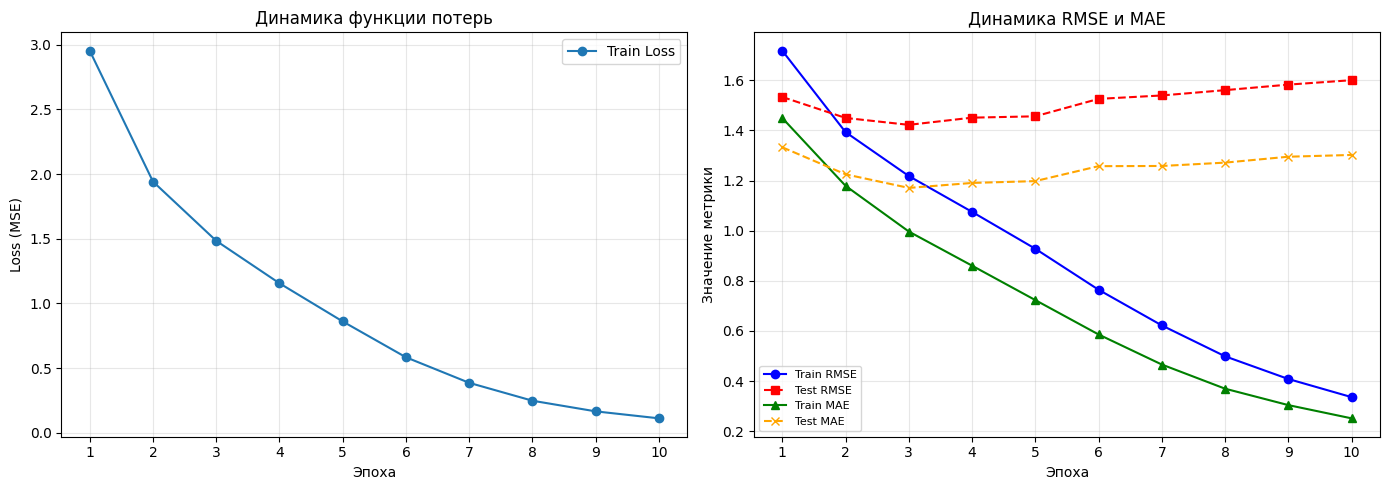

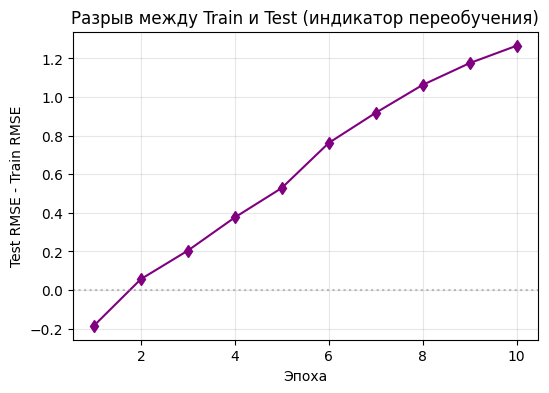


Recommendations for random users:
User 608: Recommended item indices [6942 3945 2230  259 2188] (scores: ['7.13', '7.01', '6.69', '6.54', '6.50'])
User 166: Recommended item indices [2342 3269 2839 3945 3316] (scores: ['5.78', '4.91', '4.89', '4.88', '4.84'])
User 983: Recommended item indices [2342   13 4956 2748 5134] (scores: ['8.85', '7.54', '7.39', '7.06', '7.04'])
User 790: Recommended item indices [3891 2342  204 4550 3804] (scores: ['7.63', '7.40', '7.37', '7.35', '7.34'])
User 917: Recommended item indices [6756 2848 4956 2837 2803] (scores: ['6.95', '6.92', '6.87', '6.83', '6.82'])


In [107]:
import matplotlib.pyplot as plt

# Списки для сохранения истории метрик
train_losses = []
train_rmse_history = []
train_mae_history = []
test_rmse_history = []
test_mae_history = []

# ==========================================
# ЦИКЛ ОБУЧЕНИЯ С ОТОбражением метрик
# ==========================================
for epoch in range(10):
    model.train()
    total_loss = 0
    all_predictions = []
    all_ratings = []
    
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().detach().numpy())
        all_ratings.extend(ratings.cpu().detach().numpy())

    # Метрики на тренировочной выборке
    epoch_rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    epoch_mae = mean_absolute_error(all_ratings, all_predictions)
    
    # Сохраняем метрики
    train_losses.append(total_loss / len(train_loader))
    train_rmse_history.append(epoch_rmse)
    train_mae_history.append(epoch_mae)
    
    # Вывод метрик в консоль
    print(f'Epoch {epoch+1}/10 | Loss: {total_loss/len(train_loader):.4f} | '
          f'Train RMSE: {epoch_rmse:.4f} | Train MAE: {epoch_mae:.4f}')
    
    # === Оценка на тестовой выборке после каждой эпохи (для мониторинга переобучения) ===
    model.eval()
    test_preds_epoch = []
    test_ratings_epoch = []
    with torch.no_grad():
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            predictions = model(users, items)
            test_preds_epoch.extend(predictions.cpu().numpy())
            test_ratings_epoch.extend(ratings.cpu().numpy())
    
    epoch_test_rmse = math.sqrt(mean_squared_error(test_ratings_epoch, test_preds_epoch))
    epoch_test_mae = mean_absolute_error(test_ratings_epoch, test_preds_epoch)
    
    test_rmse_history.append(epoch_test_rmse)
    test_mae_history.append(epoch_test_mae)
    
    print(f'           | Test RMSE: {epoch_test_rmse:.4f} | Test MAE: {epoch_test_mae:.4f}')

# ==========================================
# ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТЕ
# ==========================================
print(f'\n=== Итоговые метрики на тестовой выборке ===')
print(f'Test RMSE: {test_rmse_history[-1]:.4f}')
print(f'Test MAE: {test_mae_history[-1]:.4f}')

# ==========================================
# ПОСТРОЕНИЕ ГРАФИКОВ
# ==========================================
epochs = range(1, 11)

plt.figure(figsize=(14, 5))

# График 1: Функция потерь (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.xlabel('Эпоха')
plt.ylabel('Loss (MSE)')
plt.title('Динамика функции потерь')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(epochs)

# График 2: Метрики RMSE и MAE (Train и Test)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_rmse_history, label='Train RMSE', marker='o', color='blue')
plt.plot(epochs, test_rmse_history, label='Test RMSE', marker='s', color='red', linestyle='--')
plt.plot(epochs, train_mae_history, label='Train MAE', marker='^', color='green')
plt.plot(epochs, test_mae_history, label='Test MAE', marker='x', color='orange', linestyle='--')
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики')
plt.title('Динамика RMSE и MAE')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)
plt.xticks(epochs)

plt.tight_layout()
plt.show()

# ==========================================
# ДОПОЛНИТЕЛЬНО: График разницы Train/Test (переобучение)
# ==========================================
plt.figure(figsize=(6, 4))
rmse_gap = [t - v for t, v in zip(test_rmse_history, train_rmse_history)]
plt.plot(epochs, rmse_gap, marker='d', color='purple')
plt.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Эпоха')
plt.ylabel('Test RMSE - Train RMSE')
plt.title('Разрыв между Train и Test (индикатор переобучения)')
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# РЕКОМЕНДАЦИИ ДЛЯ СЛУЧАЙНЫХ ПОЛЬЗОВАТЕЛЕЙ
# ==========================================
# Исправлено: 'user_id' -> 'userID' (camelCase)
random_users = np.random.choice(df['userID'].unique(), size=5)

print("\nRecommendations for random users:")
for user_id in random_users:
    user_tensor = torch.tensor([user_id] * num_items, dtype=torch.long).to(device)
    item_tensor = torch.tensor(range(num_items), dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).cpu().numpy()

    top_items = predictions.argsort()[-5:][::-1]
    
    # Показываем оригинальные ID (если вы делали маппинг, можно добавить обратное преобразование)
    print(f"User {user_id + 1}: Recommended item indices {top_items} "
          f"(scores: {[f'{predictions[i]:.2f}' for i in top_items]})")

На основе полученных значений метрик RMSE и MAE мы видим что для тренировочной выборки эти метрики падают, однако для тестовой выборки эти значения после 3 эпохи начинают расти, что говорит о переобучение модели. График разрыва RMSE между тренировочной и тестовой выборкой также это подтверждает, значение 1.25 говорит об переобучение модели.

На основе рекомендации мы видим что система дает различные рекомендации для различных пользователей. Мы можем наблюдать низкие значения для пользователя 166, что может говорить о наличие проблемы холодного старта и недостаточности данных об активности данного пользователя. Также на основе сгенерированных предпочтений можно наблюдать, что песни 2342 3945 4956 рекомендуются сразу нескольким пользователям.